# STEP 6

Load the detector and the net to train

In [ ]:
from art.defences.detector.evasion import BinaryInputDetector
from art.utils import get_file, load_dataset
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art import config

if tf.__version__[0] == "2":
    tf.compat.v1.disable_eager_execution()

path = get_file('BID_eps=0.05.h5',extract=False, path=config.ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')


detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

Create the dataset. It is composed by 2000 samples:
- 1000 are clean images
- 1000 are FGSM adversarial samples generate with different values for epsilon

In [ ]:
import os
from PIL import Image
from torchvision import transforms
import numpy

#for each file in the directory add it to a dataloader
dataset_clean = []
labels_clean = []
dataset_adv = []
labels_adv = []

base_directory = "1000Campioni"
for root, dirs, files in os.walk(base_directory):

    for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)

            # Definisci le trasformazioni per preprocessare l'immagine
            preprocess = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
            ])

            # Applica le trasformazioni all'immagine
            input_image = preprocess(image)

            #add input images to a list
            dataset_clean.append(input_image)


epsilon_list = [0.01, 0.05, 0.1, 0.2]
#read new_class_name.csv
import csv
import pandas as pd

class_name = pd.read_csv("new_class_name.csv", header=None)
class_name = class_name[0]
class_name = class_name.tolist()

count = 0
for epsilon in epsilon_list:
    dir = os.path.join("adv","NFGSM","Epsilon_{epsilon}".format(epsilon=epsilon))
    for i in range(0,25):
        class_dir = os.path.join(dir,class_name[count])
        #get all the images in the class directory
        for root, dirs, files in os.walk(class_dir):
            for file in files:
                if file.endswith(".jpg"):
                    image_path = os.path.join(root, file)
                    image = Image.open(image_path)

                    # Definisci le trasformazioni per preprocessare l'immagine
                    preprocess = transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                    ])

                    # Applica le trasformazioni all'immagine
                    input_image = preprocess(image)

                    #add input images to a list
                    dataset_adv.append(input_image)
            count += 1

In [ ]:
import numpy as np
dataset_clean = np.array([np.array(i) for i in dataset_clean])
dataset_adv = np.array([np.array(i) for i in dataset_adv])

x_train_clean = dataset_clean[:700]
x_test_clean = dataset_clean[700:]
x_train_adv = dataset_adv[:700]
x_test_adv = dataset_adv[700:]

x_train_detector = np.concatenate((x_train_clean, x_train_adv), axis=0)

x_train_detector = np.transpose(x_train_detector, (0, 2, 3, 1))

nb_train = 700
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)


In [ ]:
x_test_detector = np.concatenate((x_test_clean, x_test_adv), axis=0)
x_test_detector = np.transpose(x_test_detector, (0, 2, 3, 1))

nb_test_clean = len(x_test_clean)
nb_test_adv = len(x_test_adv)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test_clean), np.array([[0,1]]*nb_test_adv)), axis=0)

In [ ]:
print(x_train_detector.shape)
print(y_train_detector.shape)

print(x_test_detector.shape)
print(y_test_detector.shape)

(1400, 32, 32, 3)
(1400, 2)
(601, 32, 32, 3)
(601, 2)


Train the detector

In [ ]:
detector.fit(x_train_detector,y_train_detector, nb_epochs=10, batch_size=32)


Test the detector

In [ ]:
test = np.transpose(x_test_clean,  (0, 2, 3, 1))
_, is_adversarial = detector.detect(test)
flag_adv = np.sum(is_adversarial)

print("Clean images detected as adversarial: ", flag_adv)

Clean images detected as adversarial:  4


In [ ]:
dir = os.path.join("adv","NFGSM","Epsilon_0.05")
test_adv = []
for root, dirs, files in os.walk(dir):
     for file in files:
        if file.endswith(".jpg"):
            image_path = os.path.join(root, file)
            image = Image.open(image_path)

            # Definisci le trasformazioni per preprocessare l'immagine
            preprocess = transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor(),
            ])

            # Applica le trasformazioni all'immagine
            input_image = preprocess(image)

            #add input images to a list
            test_adv.append(input_image)


test_adv = np.array([np.array(i) for i in test_adv])
test = np.transpose(test_adv,  (0, 2, 3, 1))
_, is_adversarial = detector.detect(test)
flag_adv = np.sum(is_adversarial)

print("Adversarial images detected as adversarial: ", flag_adv)



Adversarial images detected as adversarial:  639


In [ ]:
test = np.transpose(x_test_adv,  (0, 2, 3, 1))
_, is_adversarial = detector.detect(test)
flag_adv = np.sum(is_adversarial)

print("Adversarial images detected as adversarial: ", flag_adv)

Adversarial images detected as adversarial:  298


# Evaluate Accuracy

In [ ]:

_, is_adversarial = detector.detect(x_test_detector)

correct = 0
for i in range(len(is_adversarial)):
    if is_adversarial[i] == True and y_test_detector[i][0] == 0:
        correct += 1
    elif is_adversarial[i] == False and y_test_detector[i][1] == 0:
        correct += 1

print(correct/len(is_adversarial))

0.9883527454242929


## Save the model

In [ ]:
#Saving model architecture to JSON file
model_json = detector_model.to_json()

#Saving to local directory
with open('model.json','w') as json_file:
  json_file.write(model_json)

#Saving weights of model
detector_model.save_weights('model_h5',save_format='h5') # h5 format

# Load the model

In [ ]:
#reloading model from JSON file
json_file = open('model.json','r')
loaded_model_json = json_file.read()

#loading model from JSON file
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights('model_h5')
loaded_model.summary()#reloading model from JSON file
json_file = open('model.json','r')
loaded_model_json = json_file.read()

#loading model from JSON file
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights('model_h5')
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 32, 16)           64        ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 32, 32, 16)           0         ['batch_normalization_1[

In [ ]:
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=loaded_model, use_logits=False)
detector_p = BinaryInputDetector(detector_classifier)


## Evaluate the model for Untargeted FGSM Attacks
For each value of epsilon we evaluate the accuracy of the detector

In [ ]:
import os
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

path = os.path.join("adv","NFGSM")
accuracy = []
for p in os.listdir(path):
    dir = os.path.join(path, p)
    dataset_adv = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)

                # Definisci le trasformazioni per preprocessare l'immagine
                preprocess = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                ])

                # Applica le trasformazioni all'immagine
                input_image = preprocess(image)

                #add input images to a list
                dataset_adv.append(input_image)

    dataset_adv = np.array([np.array(i) for i in dataset_adv])
    test = np.transpose(dataset_adv,  (0, 2, 3, 1))
    _, is_adversarial = detector_p.detect(test)
    flag_adv = np.sum(is_adversarial)
    accuracy.append(flag_adv/len(is_adversarial))
    print("Adversarial images detected as adversarial: ", flag_adv)

c:\Users\lucia\anaconda3\envs\AI4CS2\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Adversarial images detected as adversarial:  6
Adversarial images detected as adversarial:  9
Adversarial images detected as adversarial:  11
Adversarial images detected as adversarial:  639
Adversarial images detected as adversarial:  994
Adversarial images detected as adversarial:  1001
Adversarial images detected as adversarial:  1001
Adversarial images detected as adversarial:  1001
Adversarial images detected as adversarial:  1001
Adversarial images detected as adversarial:  1001


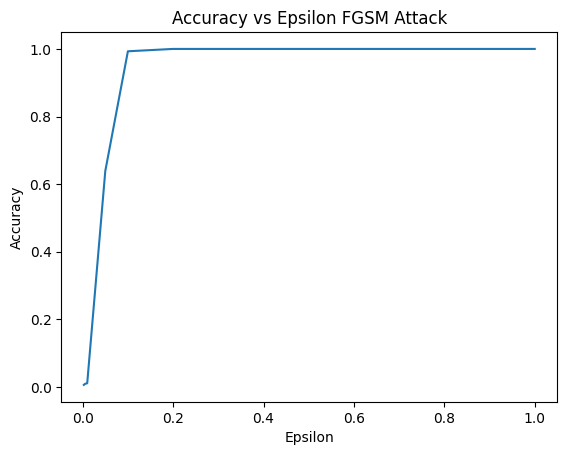

In [ ]:
#plot the accuracy vs epsilon
import matplotlib.pyplot as plt
plt.plot(epsilon_list, accuracy)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon FGSM Attack")
plt.show()

## Evaluate the model for Targeted BIM Attacks
For each value of epsilon we evaluate the accuracy of the detector

In [ ]:
import os
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

path = os.path.join("adv","TBIM","Epsilon")
accuracy = []
for p in os.listdir(path):
    dir = os.path.join(path, p)
    dataset_adv = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)

                # Definisci le trasformazioni per preprocessare l'immagine
                preprocess = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                ])

                # Applica le trasformazioni all'immagine
                input_image = preprocess(image)

                #add input images to a list
                dataset_adv.append(input_image)

    dataset_adv = np.array([np.array(i) for i in dataset_adv])
    test = np.transpose(dataset_adv,  (0, 2, 3, 1))
    _, is_adversarial = detector_p.detect(test)
    flag_adv = np.sum(is_adversarial)
    accuracy.append(flag_adv/len(is_adversarial))
    print("Adversarial images detected as adversarial: ", flag_adv)

Adversarial images detected as adversarial:  8
Adversarial images detected as adversarial:  9
Adversarial images detected as adversarial:  12
Adversarial images detected as adversarial:  406
Adversarial images detected as adversarial:  894
Adversarial images detected as adversarial:  998
Adversarial images detected as adversarial:  1000
Adversarial images detected as adversarial:  1000
Adversarial images detected as adversarial:  1000
Adversarial images detected as adversarial:  1000


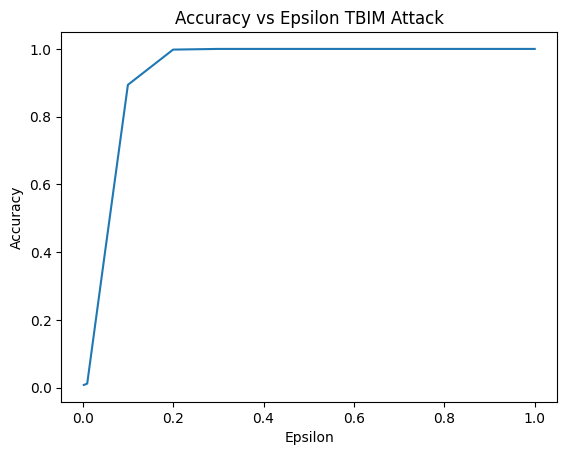

In [ ]:
#plot the accuracy vs epsilon
import matplotlib.pyplot as plt
plt.plot(epsilon_list, accuracy)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon TBIM Attack")
plt.show()

## Evaluate the model for Untargeted PGD Attacks
For each value of epsilon we evaluate the accuracy of the detector

In [ ]:
import os
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

path = os.path.join("adv","NPGD","Epsilon")
accuracy = []
for p in os.listdir(path):
    dir = os.path.join(path, p)
    dataset_adv = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)

                # Definisci le trasformazioni per preprocessare l'immagine
                preprocess = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                ])

                # Applica le trasformazioni all'immagine
                input_image = preprocess(image)

                #add input images to a list
                dataset_adv.append(input_image)

    dataset_adv = np.array([np.array(i) for i in dataset_adv])
    test = np.transpose(dataset_adv,  (0, 2, 3, 1))
    _, is_adversarial = detector_p.detect(test)
    flag_adv = np.sum(is_adversarial)
    accuracy.append(flag_adv/len(is_adversarial))
    print("Adversarial images detected as adversarial: ", flag_adv)

Adversarial images detected as adversarial:  2
Adversarial images detected as adversarial:  1
Adversarial images detected as adversarial:  3
Adversarial images detected as adversarial:  90
Adversarial images detected as adversarial:  185
Adversarial images detected as adversarial:  199
Adversarial images detected as adversarial:  200
Adversarial images detected as adversarial:  200
Adversarial images detected as adversarial:  200
Adversarial images detected as adversarial:  200


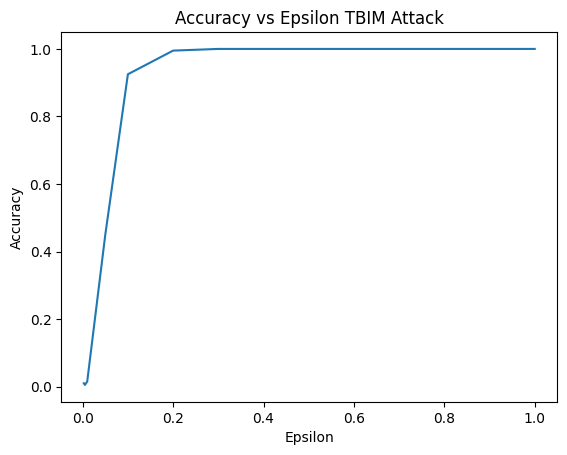

In [ ]:
#plot the accuracy vs epsilon
import matplotlib.pyplot as plt
plt.plot(epsilon_list, accuracy)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon TBIM Attack")
plt.show()

## Evaluate the model for Untargeted DeepFool Attacks
For each value of epsilon we evaluate the accuracy of the detector

In [ ]:
import os
epsilon_list = [0.0025, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.75, 1]

path = os.path.join("adv","NDF")
accuracy = []
for p in os.listdir(path):
    dir = os.path.join(path, p)
    dataset_adv = []
    for root, dirs, files in os.walk(dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = Image.open(image_path)

                # Definisci le trasformazioni per preprocessare l'immagine
                preprocess = transforms.Compose([
                    transforms.Resize((32, 32)),
                    transforms.ToTensor(),
                ])

                # Applica le trasformazioni all'immagine
                input_image = preprocess(image)

                #add input images to a list
                dataset_adv.append(input_image)

    dataset_adv = np.array([np.array(i) for i in dataset_adv])
    test = np.transpose(dataset_adv,  (0, 2, 3, 1))
    _, is_adversarial = detector_p.detect(test)
    flag_adv = np.sum(is_adversarial)
    accuracy.append(flag_adv/len(is_adversarial))
    print("Adversarial images detected as adversarial: ", flag_adv)

Adversarial images detected as adversarial:  5
Adversarial images detected as adversarial:  5
Adversarial images detected as adversarial:  4
Adversarial images detected as adversarial:  4
Adversarial images detected as adversarial:  4
Adversarial images detected as adversarial:  4
Adversarial images detected as adversarial:  5
Adversarial images detected as adversarial:  5
Adversarial images detected as adversarial:  5
Adversarial images detected as adversarial:  4


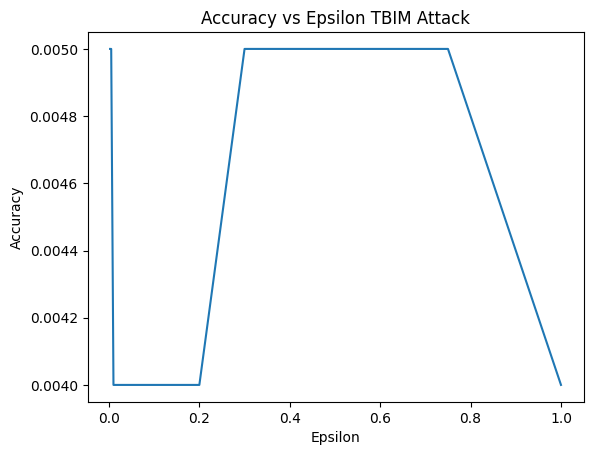

In [ ]:
#plot the accuracy vs epsilon
import matplotlib.pyplot as plt
plt.plot(epsilon_list, accuracy)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epsilon TBIM Attack")
plt.show()